In [1]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: Mar 3, 2022
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm

# Set panda's options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)

# Better graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-poster')

In [3]:
stays = pd.read_csv('../data/stays31080.csv.gz')

In [9]:
all_geoids = set()
all_pois = set()
all_sequences = []
stays = stays[['user','fsq_id', 'ini_dat']]
grouped_users = stays.groupby('user')    

# Things we need

1. fsq_id + ini_dat data to replicate with a GAN
2. fsq_id to long lat map for downstream science

-----

1. Learn GAN
2. Do science on raw data
3. Do science on GAN output
4. Do science on OPAL

Text(0.5, 0, 'Sequence Length of User')

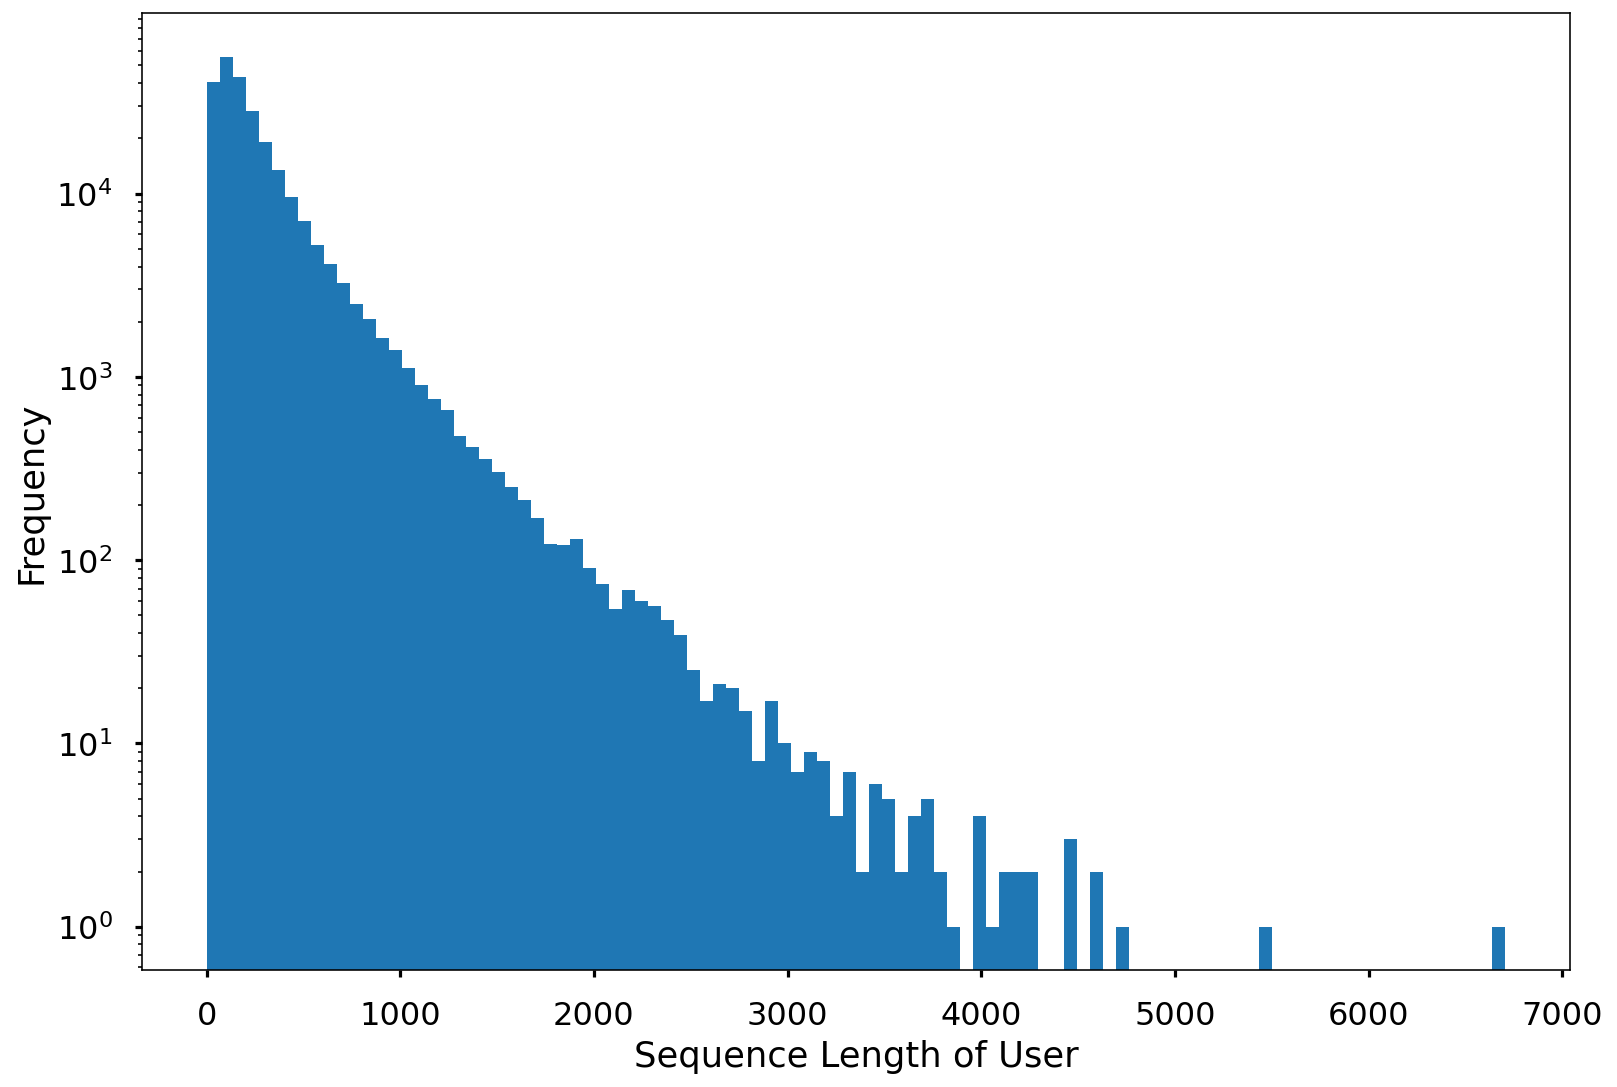

In [29]:
seq_lengths = stays['user'].value_counts()
seq_lengths.plot.hist(logy=True, bins = 100)
plt.xlabel('Sequence Length of User')

239509


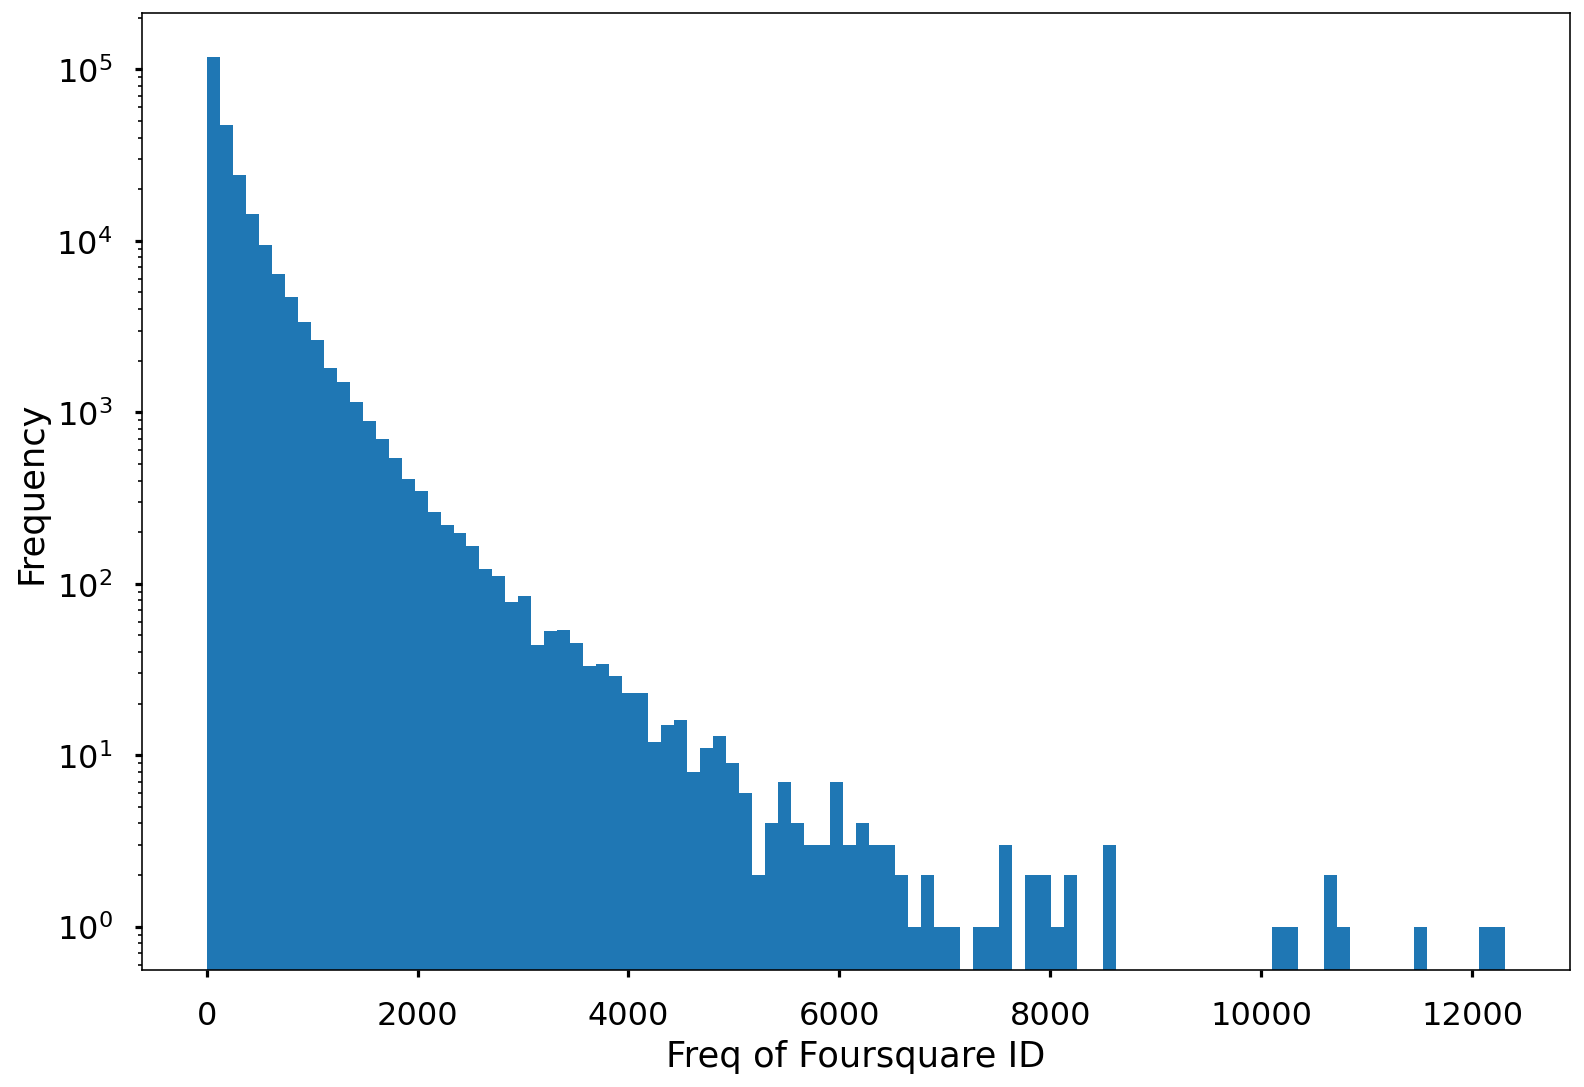

In [60]:
fsq_counts = stays['fsq_id'].value_counts()
fsq_counts.plot.hist(logy=True, bins = 100)
plt.xlabel('Freq of Foursquare ID')
print(len(fsq_counts))

In [48]:
all_sequences = []
for i, (user, user_df) in enumerate(tqdm(grouped_users)):
    user_df = user_df.sort_values(by='ini_dat')
    time_diff = user_df['ini_dat'].diff()
    split_points = np.where(time_diff > 60*60*24)[0]
    previous_split = 0
    for split_point in split_points:
        if split_point - previous_split > 5:
            seq = user_df[previous_split:split_point]
            all_sequences.append((seq['fsq_id'].values, seq['ini_dat'].values))
            previous_split=split_point

100%|██████████| 243644/243644 [02:44<00:00, 1479.59it/s]


In [63]:
len(all_sequences)

3034276

In [62]:
!open .

In [61]:
with open('../data/POI_sequences.pickle', 'wb') as f:
    pickle.dump(all_sequences, f)

(array([601368., 401482., 290576., 221916., 175169., 141903., 116512.,
         97195.,  83364.,  71722.,  61838.,  54710.,  48283.,  42971.,
         38730.,  35029.,  31845.,  28840.,  26386.]),
 array([ 5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,
        16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5]),
 <BarContainer object of 19 artists>)

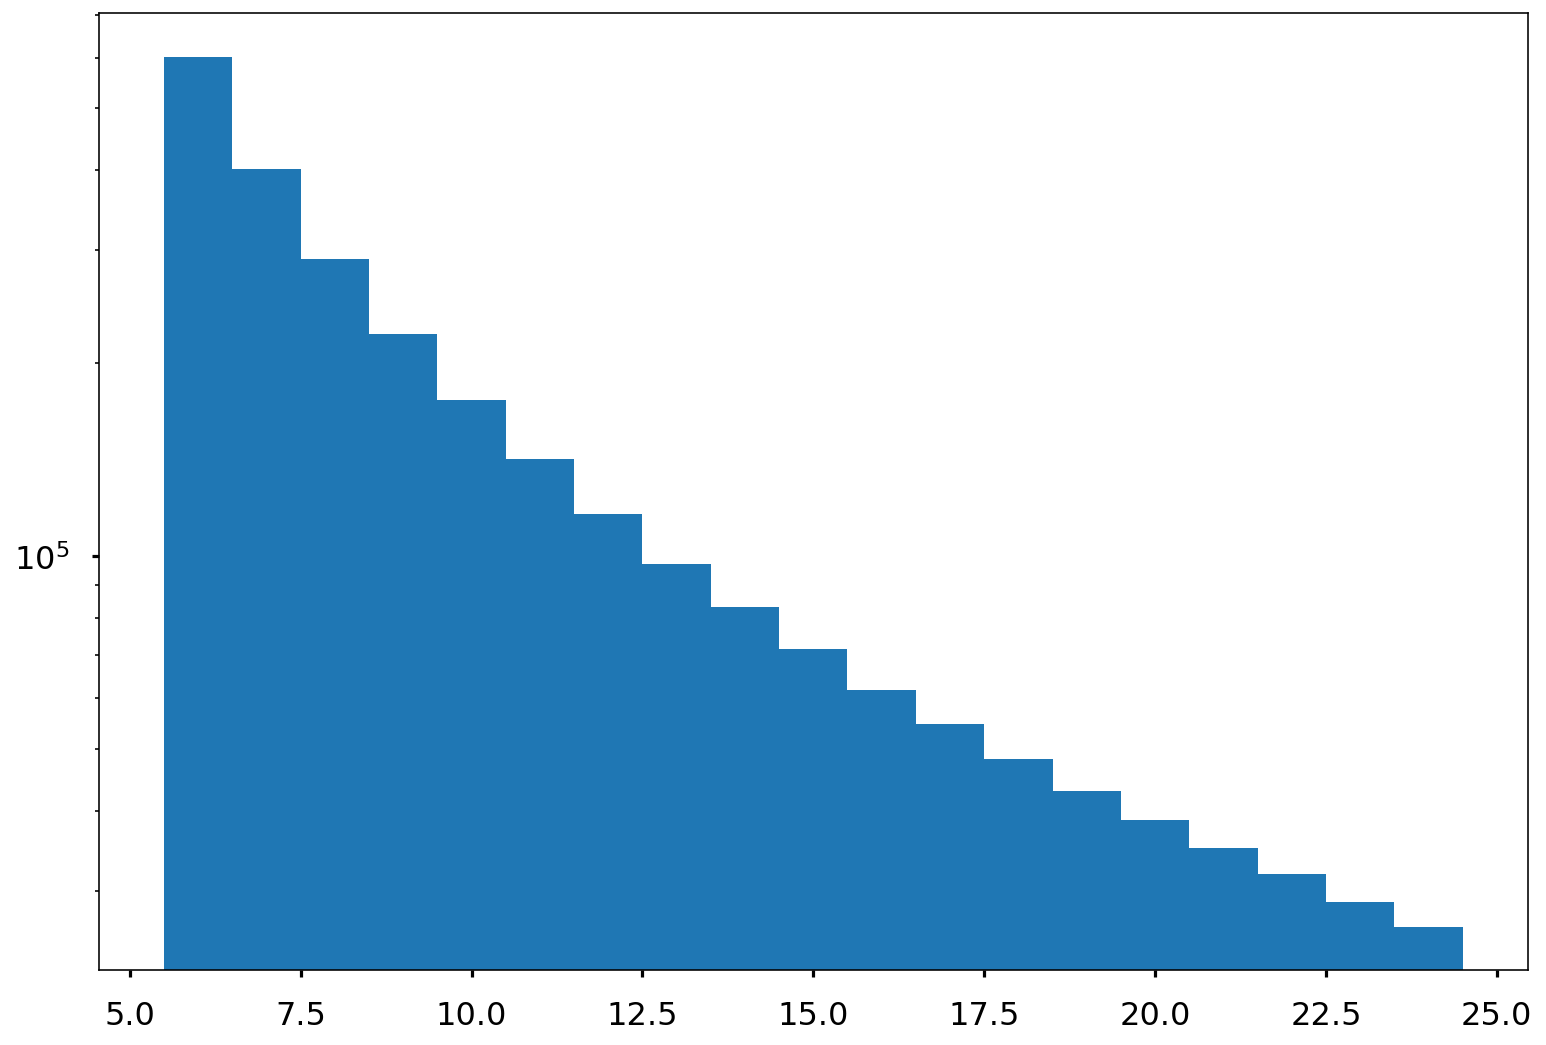

In [57]:
plt.hist([len(s[0]) for s in all_sequences], bins=np.arange(5.5,25.5), log=True)

In [ ]:
all_geoids = set()
all_pois = set()
all_sequences = []
stays = stays[['user','GEOID_home', 'fsq_id', 'ini_dat']]
grouped_users = stays.groupby('user')    
for i, (user, user_df) in enumerate(tqdm(grouped_users)):
    user_df = user_df.sort_values(by='ini_dat')
    home = user_df['GEOID_home'].unique()[0]
    all_geoids.update([home])
    all_pois.update(set(user_df['fsq_id']))
    user_df = user_df[['GEOID','ini_dat','datetime','time','duration']]
    seq = [(home,0, 'H')]
    for idx, row in user_df.iterrows():
        if row['GEOID'] == home:
            if len(seq) > 5:
                seq.append((row['GEOID'], row['time'], 'H'))
                all_sequences.append(seq)
                seq = []
                continue
        seq.append((row['GEOID'], row['time'], 'A'))
    if len(seq) > 5:
        all_sequences.append(seq)
        seq = []
